In [76]:
import numpy as np
import math
from scipy.spatial import distance
from scipy.optimize import curve_fit
from copy import copy
from random import random
from tqdm import tqdm
import scipy as scp

In [77]:
from sklearn.datasets import load_digits
digits = load_digits()

In [78]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [87]:
EPS = 1e-3

def curve(x, a, b):
  return 1.0 / (1.0 + a * x ** (2.0 * b))
    

def attractive_force(dist_sq, a, b):
  if dist_sq > 0.0:
    result = -2.0 * a * b * pow(dist_sq, b - 1.0)
    result /= a * pow(dist_sq, b) + 1.0
  else:
    result = 0.0
  return result


def repilsive_force(dist_sq, a, b):
  result = 2.0 * b
  result /= (EPS + dist_sq) * (
      a * pow(dist_sq, b) + 1
  )
  return result


In [81]:
def find_ab_params(min_dist):
  xv = np.linspace(0.0, 3.0, 300)
  yv = np.zeros(xv.shape)
  yv[xv < min_dist] = 1.0
  yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist))
  params, covar = curve_fit(curve, xv, yv)
  return params[0], params[1]

In [82]:
def smooth_single_dist(knn_dist):
  sigma_lower = 0.0
  sigma_upper = None
  sigma = 1.0

  target = np.log2(len(knn_dist))
  while sigma_upper is None or sigma_upper - sigma_lower > EPS:
    if sigma > target:
      sigma_upper = sigma
    else:
      sigma_lower = sigma

    if sigma_upper is None:
      sigma *= 2.0
    else:
      sigma = (sigma_lower + sigma_upper) / 2.0

  non_zero_dist = knn_dist[knn_dist > 0]
  if len(non_zero_dist) > 0:
    rho = non_zero_dist[0]
  else:
    rho = EPS

  return sigma, rho

def smooth_dists(knn_dists):
  sigmas = np.zeros(len(knn_dists), dtype=np.float32)
  rhos = np.zeros(len(knn_dists), dtype=np.float32)

  for i, knn_dist in enumerate(knn_dists):
    sigmas[i], rhos[i] = smooth_single_dist(knn_dists)

  return sigmas, rhos

In [96]:
class Umap(object):
    
  def __init__(self, n_neighbors=15, n_components=2, min_dist=0.1, n_epochs=100):
    self.n_neighbors = n_neighbors
    self.n_components = n_components
    self.n_epochs = n_epochs
    self.a, self.b = find_ab_params(min_dist)
    
  def fit_transform(self, X):
    graph = self._build_graph(X)

    Y = self._build_embedding(graph)
    Y = self._optimize_embedding(graph, Y)
    return Y
    
  def _sdist(self, x_i, x_j):
    return distance.euclidean(x_i, x_j)

  def _tdist(self, y_i, y_j):
    return distance.euclidean(y_i, y_j) ** 2
    
  def _find_neighbors(self, X):
    idxs = np.zeros((len(X), self.n_neighbors), dtype=np.int32)
    dists = np.zeros((len(X), self.n_neighbors), dtype=np.float32)

    for i, x_i in enumerate(X):
      dists_i = np.zeros(len(X), dtype=np.float32)
      for j, x_j in enumerate(X):
        if i == j:
          continue

        dists_i[j] = self._sdist(x_i, x_j)
      idxs[i] = np.argsort(dists_i)[1 : self.n_neighbors + 1]
      dists[i] = dists_i[idxs[i]]

    return idxs, dists

  def _build_graph(self, X):
    knn_idxs, knn_dists = self._find_neighbors(X)
    sigmas, rhos = smooth_dists(knn_dists)

    rows = np.zeros(len(X) * self.n_neighbors, dtype=np.int32)
    cols = np.zeros(len(X) * self.n_neighbors, dtype=np.int32)
    vals = np.zeros(len(X) * self.n_neighbors, dtype=np.float32)

    for i in range(len(X)):
      for j in range(self.n_neighbors):
        if knn_idxs[i][j] == -1 or knn_idxs[i][j] == i:
            continue

        if knn_dists[i][j] - rhos[i] <= 0.0 or sigmas[i] == 0.0:
          val = 1.0
        else:
          val = np.exp(-((knn_dists[i][j] - rhos[i]) / (sigmas[i])))

        rows[i * self.n_neighbors + j] = i
        cols[i * self.n_neighbors + j] = knn_idxs[i][j]
        vals[i * self.n_neighbors + j] = val

    graph = scp.sparse.coo_matrix(
        (vals, (rows, cols)), shape=(len(X), len(X))
    )
    return graph

  def _build_embedding(self, graph):
    diag = np.asarray(graph.sum(axis=0))

    I = scp.sparse.identity(graph.shape[0], dtype=np.float64)
    D = scp.sparse.spdiags(
        1.0 / np.sqrt(diag), [0], graph.shape[0], graph.shape[0]
    )
    L = I - D * graph * D

    k = self.n_components + 1
    e_vals, e_vecs = scp.sparse.linalg.eigsh(L, self.n_components + 1)

    order = np.argsort(e_vals)[1:k]
    return e_vecs[:, order]

  def _optimize_embedding(self, graph, Y):
    alpha = 1.0
    for e in tqdm(range(self.n_epochs)):

      for (i, j, v) in zip(graph.row, graph.col, graph.data):
        if random() < v:
          force = attractive_force(self._tdist(Y[i], Y[j]), self.a, self.b)
          Y[i] += alpha * force * (Y[i] - Y[j])

          neg_idxs = np.random.choice(graph.shape[0], 5)
          for k in neg_idxs:
            force = repilsive_force(self._tdist(Y[i], Y[k]), self.a, self.b)
            Y[i] += alpha * force * (Y[i] - Y[k])

      alpha = 1.0 - e / self.n_epochs

    return Y


In [97]:
reducer = Umap(n_epochs=100)
embedding = reducer.fit_transform(digits.data)
embedding.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


(1797, 2)

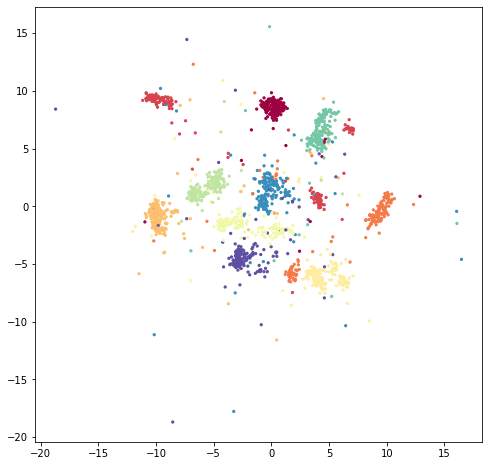

In [98]:
plt.figure(figsize=(8,8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.show()